In [2]:
!pip install --upgrade azure-cognitiveservices-vision-face
#!pip install --upgrade pillow

     |████████████████████████████████| 71kB 2.5MB/s 
     |████████████████████████████████| 92kB 5.6MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 


In [0]:
import asyncio
import io
import glob
import os
import sys
import time
import uuid
import requests
from urllib.parse import urlparse
from io import BytesIO
from PIL import Image, ImageDraw
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.vision.face.models import TrainingStatusType, Person, SnapshotObjectType, OperationStatusType
from IPython.display import Image as ImageIp

In [0]:
# Set the FACE_SUBSCRIPTION_KEY environment variable with your key as the value.
# This key will serve all examples in this document.
# 965a65b8e67244e5882ddffdf61900df
KEY = "965a65b8e67244e5882ddffdf61900df"

# Set the FACE_ENDPOINT environment variable with the endpoint from your Face service in Azure.
# This endpoint will be used in all examples.
# https://pyconface.cognitiveservices.azure.com/
ENDPOINT = "https://pyconface.cognitiveservices.azure.com/"

In [0]:
# Create an authenticated FaceClient.
face_client = FaceClient(ENDPOINT, CognitiveServicesCredentials(KEY))

# Simple Face Detection

Drawing rectangle around face... see popup for results.


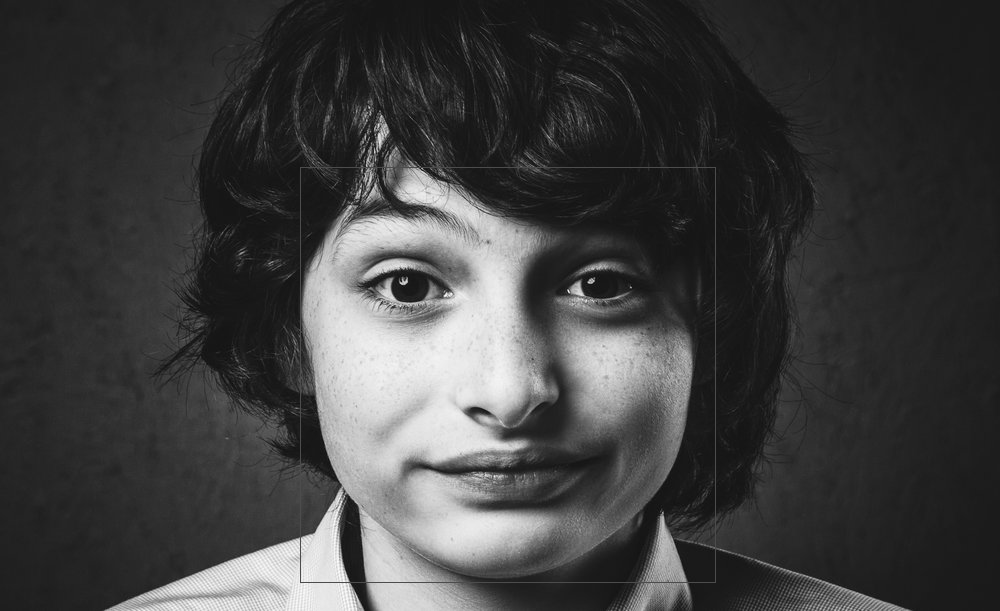

In [0]:
# Detect a face in an image that contains a single face
#single_face_image_url = 'https://raw.githubusercontent.com/Microsoft/Cognitive-Face-Windows/master/Data/detection1.jpg'
single_face_image_url = 'https://images.squarespace-cdn.com/content/v1/54f52b66e4b06c271d076bd9/1536247240550-K6LLIK8Q4BOQANG6UHDA/ke17ZwdGBToddI8pDm48kBy8mj_hQ5wvuIC8u4J-J8F7gQa3H78H3Y0txjaiv_0fDoOvxcdMmMKkDsyUqMSsMWxHk725yiiHCCLfrh8O1z4YTzHvnKhyp6Da-NYroOW3ZGjoBKy3azqku80C789l0vApyh6NsI3juLutxTva2hhQtnKS6SdPm02O0ZHHGx6f9SnSwLTGk1ktcUckUGygdA/Faces_010.jpg'
single_image_name = os.path.basename(single_face_image_url)
detected_faces = face_client.face.detect_with_url(url=single_face_image_url)
if not detected_faces:
    raise Exception('No face detected from image {}'.format(single_image_name))


# Convert width height to a point in a rectangle
def getRectangle(faceDictionary):
    rect = faceDictionary.face_rectangle
    left = rect.left
    top = rect.top
    right = left + rect.width
    bottom = top + rect.height

    return ((left, top), (right, bottom))


# Download the image from the url
response = requests.get(single_face_image_url)
img = Image.open(BytesIO(response.content))

# For each face returned use the face rectangle and draw a red box.
print('Drawing rectangle around face... see popup for results.')
draw = ImageDraw.Draw(img)
for face in detected_faces:
    draw.rectangle(getRectangle(face), outline='red')

display(img)


# Simple detection and search registered face on picture

In [0]:
# Detect a face in an image that contains a single face
single_face_image_url = 'https://www.biography.com/.image/t_share/MTQ1MzAyNzYzOTgxNTE0NTEz/john-f-kennedy---mini-biography.jpg'
single_image_name = os.path.basename(single_face_image_url)
detected_faces = face_client.face.detect_with_url(url=single_face_image_url)
if not detected_faces:
    raise Exception('No face detected from image {}'.format(single_image_name))

# Display the detected face ID in the first single-face image.
# Face IDs are used for comparison to faces (their IDs) detected in other images.
print('Detected face ID from', single_image_name, ':')
for face in detected_faces: print (face.face_id)
print()

# Save this ID for use in Find Similar
first_image_face_ID = detected_faces[0].face_id

Detected face ID from john-f-kennedy---mini-biography.jpg :
5b3c6380-d7c8-40cf-99fb-448ab199fd3e



In [0]:
# Detect the faces in an image that contains multiple faces
# Each detected face gets assigned a new ID
#multi_face_image_url = "http://www.historyplace.com/kennedy/president-family-portrait-closeup.jpg"
multi_face_image_url = 'https://rec-end.elnuevodia.com/images/tn/33/0/723/600/900/789/2017/10/27/8dad2715-8cc6-4db5-b159-f1d64f4ffcaf.jpg'

multi_image_name = os.path.basename(multi_face_image_url)
detected_faces2 = face_client.face.detect_with_url(url=multi_face_image_url)


# Search through faces detected in group image for the single face from first image.
# First, create a list of the face IDs found in the second image.
second_image_face_IDs = list(map(lambda x: x.face_id, detected_faces2))
# Next, find similar face IDs like the one detected in the first image.
similar_faces = face_client.face.find_similar(face_id=first_image_face_ID, face_ids=second_image_face_IDs)
if not similar_faces[0]:
    print('No similar faces found in', multi_image_name, '.')


# Print the details of the similar faces detected
print('Similar faces found in', multi_image_name + ':')
for face in similar_faces:
    first_image_face_ID = face.face_id
    # The similar face IDs of the single face image and the group image do not need to match,
    # they are only used for identification purposes in each image.
    # The similar faces are matched using the Cognitive Services algorithm in find_similar().
    face_info = next(x for x in detected_faces2 if x.face_id == first_image_face_ID)
    if face_info:
        print('  Face ID: ', first_image_face_ID)
        print('  Face rectangle:')
        print('    Left: ', str(face_info.face_rectangle.left))
        print('    Top: ', str(face_info.face_rectangle.top))
        print('    Width: ', str(face_info.face_rectangle.width))
        print('    Height: ', str(face_info.face_rectangle.height))
        draw.rectangle(getRectangle(face_info), outline='red')




Similar faces found in 8dad2715-8cc6-4db5-b159-f1d64f4ffcaf.jpg:
  Face ID:  c0384d50-2b30-45c2-a60a-d66fe01e3433
  Face rectangle:
    Left:  168
    Top:  202
    Width:  87
    Height:  87


Drawing rectangle around face... see popup for results.


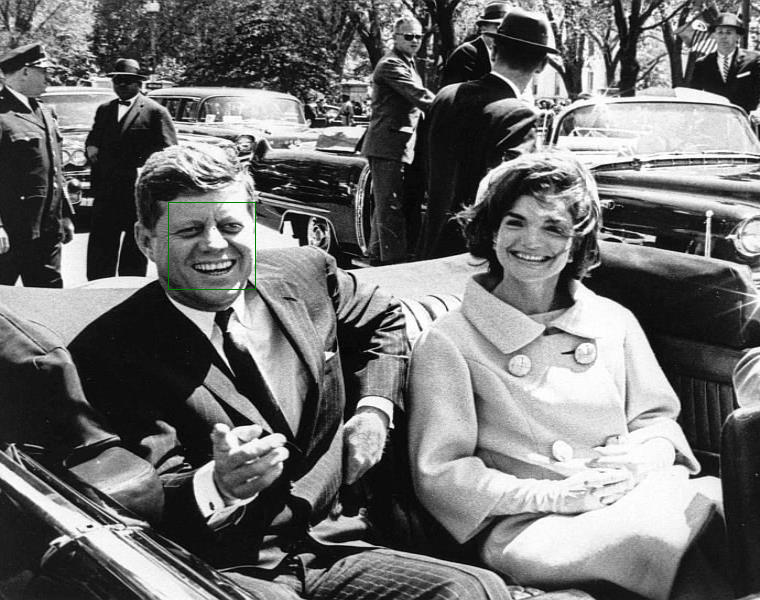

In [0]:
response = requests.get(multi_face_image_url)
img2 = Image.open(BytesIO(response.content))

# For each face returned use the face rectangle and draw a green box.
print('Drawing rectangle around face... see popup for results.')
draw = ImageDraw.Draw(img2)
for face in similar_faces:
    first_image_face_ID = face.face_id
    # The similar face IDs of the single face image and the group image do not need to match,
    # they are only used for identification purposes in each image.
    # The similar faces are matched using the Cognitive Services algorithm in find_similar().
    face_info = next(x for x in detected_faces2 if x.face_id == first_image_face_ID)
    if face_info:
        draw.rectangle(getRectangle(face_info), outline='green')

display(img2)

# **Group Training and Detection**

In [6]:
# Load the Drive helper and mount
from google.colab import drive

ROOT_FOLDER = "/content/drive"
BASE_FOLDER = f"{ROOT_FOLDER}/My Drive/pycon_worshop/final"
VALIDATION_FOLDER = f"{BASE_FOLDER}/validation"
FRAMES_FOLDER = f"{BASE_FOLDER}/frames"

drive.mount(ROOT_FOLDER, force_remount=True)
print(os.listdir(FRAMES_FOLDER))


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
['ARIEL__CALZADA', 'FELIPE__MEJIA', 'YEIMY__AREVALO']


In [7]:
# Used in the Person Group Operations,  Snapshot Operations, and Delete Person Group examples.
# You can call list_person_groups to print a list of preexisting PersonGroups.
# SOURCE_PERSON_GROUP_ID should be all lowercase and alphanumeric. For example, 'mygroupname' (dashes are OK).
PERSON_BASE_ID = "example-pycon"
PERSON_GROUP_ID = '{}-lab-group-t'.format(PERSON_BASE_ID)
print(PERSON_GROUP_ID)

example-pycon-lab-group-t


In [10]:
# Create empty Person Group. Person Group ID must be lower case, alphanumeric, and/or with '-', '_'.

print('Person group:', PERSON_GROUP_ID)
face_client.person_group.create(person_group_id=PERSON_GROUP_ID, name=PERSON_GROUP_ID)

yeimy = face_client.person_group_person.create(PERSON_GROUP_ID, "yeimy")
ariel = face_client.person_group_person.create(PERSON_GROUP_ID, "ariel")
felipe = face_client.person_group_person.create(PERSON_GROUP_ID, "felipe")



Person group: example-pycon-lab-group-t


In [11]:
'''
Detect faces and register to correct person
'''
# Find all jpeg images of friends in working directory
os.chdir(FRAMES_FOLDER)
yeimy_images = [file for file in glob.glob('*/*.jpg') if file.startswith("YEIMY")]
ariel_images = [file for file in glob.glob('*/*.jpg') if file.startswith("ARIEL")]
felipe_images = [file for file in glob.glob('*/*.jpg') if file.startswith("FELIPE")]


for image in ariel_images:
    try:
        m = open(image, 'r+b')
        face_client.person_group_person.add_face_from_stream(PERSON_GROUP_ID, ariel.person_id, m)
    except Exception as e:
        print(e)
        print(image)


for image in felipe_images:
    try:
        m = open(image, 'r+b')
        face_client.person_group_person.add_face_from_stream(PERSON_GROUP_ID, felipe.person_id, m)
    except Exception as e:
        print(e)
        print(image)

for image in yeimy_images:
    try:
        w = open(image, 'r+b')
        face_client.person_group_person.add_face_from_stream(PERSON_GROUP_ID, yeimy.person_id, w)
    except Exception as e:
        print(e)
        print(image)


(InvalidImage) No face detected in the image.
FELIPE__MEJIA/IMG_20170528_215337.jpg
(InvalidImage) No face detected in the image.
YEIMY__AREVALO/image2.jpg


In [12]:
'''
Train PersonGroup
'''
print()
print('Training the person group...')
# Train the person group
face_client.person_group.train(PERSON_GROUP_ID)

while (True):
    training_status = face_client.person_group.get_training_status(PERSON_GROUP_ID)
    print("Training status: {}.".format(training_status.status))
    print()
    if (training_status.status is TrainingStatusType.succeeded):
        break
    elif (training_status.status is TrainingStatusType.failed):
        print(training_status)
        sys.exit('Training the person group has failed.')
    time.sleep(10)


Training the person group...
Training status: running.

Training status: succeeded.



In [13]:
'''
Identify a face against a defined PersonGroup
'''
# Group image for testing against
group_photo = VALIDATION_FOLDER+'/ariel.png'


image = open(group_photo, 'r+b')

# Detect faces
face_ids = []
faces = face_client.face.detect_with_stream(image)
for face in faces:
    face_ids.append(face.face_id)

print(face_ids)

['3c5bcce8-d980-4bda-8a7c-5eaddb855a09']


In [14]:
# Identify faces
results = face_client.face.identify(face_ids, PERSON_GROUP_ID)
print('Identifying faces in {}'.format(os.path.basename(image.name)))
if not results:
    print('No person identified in the person group for faces from {}.'.format(os.path.basename(image.name)))
for person in results:
    print(person)
    print('Person for face ID {} is identified in {} with a confidence of {}.'.format(person.face_id, os.path.basename(image.name), person.candidates[0].confidence)) # Get topmost confidence score

Identifying faces in ariel.png
{'additional_properties': {}, 'face_id': '3c5bcce8-d980-4bda-8a7c-5eaddb855a09', 'candidates': [<azure.cognitiveservices.vision.face.models._models_py3.IdentifyCandidate object at 0x7f0b493c9898>]}
Person for face ID 3c5bcce8-d980-4bda-8a7c-5eaddb855a09 is identified in ariel.png with a confidence of 0.88486.


# Cleaning

In [9]:
# Delete the main person group.
face_client.person_group.delete(person_group_id=PERSON_GROUP_ID)
print("Deleted the person group {} from the source location.".format(PERSON_GROUP_ID))
print()

Deleted the person group example-pycon-lab-group-t from the source location.

